# Stock Portfolio Optimization: Modern Portfolio Theory

### Introduction to MPT
Modern Portfolio Theory (MPT), introduced by Harry Markowitz in 1952, is a mathematical framework for assembling a portfolio of assets such that the expected return is maximized for a given level of risk. One of the main principles of MPT is that investors are "risk-averse", viewing increased risk as an economic bad. This means that under MPT, increased risk should imply increased reward. This optimization study explores two types of risk and their effects on reward. 

### Components of MPT Analysis

#### Beta

The first risk is **Beta** is a financial measure of an investment's volatility in relation to the overall market whose *beta* = 1. Some asset sectors like "Consumer Staples" are less volatile to market conditions (*beta* < 1) whereas other sectors are more volatile than the market like Consumer Discretionary (*beta* > 1). 

Beta is computed using:

$$
\beta = \frac{\sigma_{\text{asset}} \cdot \rho_{\text{asset,market}}}{\sigma_{\text{market}}}
$$

Beta helps determine the level of risk associated with an investment across the Security Market Line which demonstrates the appropriate unit of extra reward for unit of extra risk.

$$
E(R_i) = R_f + \beta_i (E(R_m) - R_f)
$$
Where:
- $E(R_i)$ is the expected return of the investment,
- $R_f$ is the risk-free rate,
- $\beta_i$ is the beta of the investment,
- $E(R_m)$ is the expected market return.

#### Portfolio Volatility

The portfolio volatility, another economic bad being analyzed, is often denoted as the portfolio standard deviation $\sigma_p$ for a portfolio consisting of $N$ assets, is given by:

$$
\sigma_p = \sqrt{\sum_{i=1}^{N}\sum_{j=1}^{N} w_i w_j \sigma_{i} \sigma_{j} \rho_{ij}}
$$

Where:
- $w_i$ and $w_j$ are the weights of assets $i$ and $j$ in the portfolio,
- $\sigma_{i}$ and $\sigma_{j}$ are the standard deviations of returns for assets $i$ and $j$,
- $\rho_{ij}$ is the correlation coefficient between the returns of assets $i$ and $j$.

#### Expected Return

Reward is measured in terms of **Expected Return** from a given set of assets. 

The expected return of an asset or a portfolio is calculated using the formula:

$$
E(R) = \sum_{i=1}^{n} p_i r_i
$$

Where:
- \( E(R) \) is the expected return,
- \( p_i \) represents the probability of the \( i \)-th return,
- \( r_i \) is the \( i \)-th return,
- \( n \) is the number of different possible returns.

## Data Collection and Cleaning

#### Part 1: Data Collection

**Data Sources**

- *"stock_data_SPY.csv"*: Google Finance was used (through Google sheets) to collect weekly closing prices for stocks in the S&P 500. Only populated 286 stocks with full weekly closing price information. 

- *"stock_sectors.csv"*: Sector source url: "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies". 

In [568]:
import gams
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Reading in file data
stock_data_spy = pd.read_csv("complete_stock_data_SPY.csv")
stock_sectors = pd.read_csv("stock_sectors.csv")

# transform date
stock_data_spy['Date'] = pd.to_datetime(stock_data_spy['Date'])
stock_data_spy.set_index('Date', inplace=True)

# Calculating the necessary metrics
# Weekly returns
weekly_returns = stock_data_spy.pct_change().dropna()

# Annualized Average Return
years = (stock_data_spy.index[-1] - stock_data_spy.index[0]).days / 365.25
annualized_avg_return = ((stock_data_spy.iloc[-1] / stock_data_spy.iloc[0]) ** (1/years)) - 1

# Annualized Volatility
weekly_volatility = weekly_returns.std() 

# Beta Values
cov_matrix = weekly_returns.cov()
market_variance = weekly_returns['SPY'].var()
beta_values = cov_matrix.loc[:, 'SPY'] / market_variance

# Compiling the data
data_metrics = pd.DataFrame({
    'Annualized Average Return': annualized_avg_return,
    'Weekly Volatility': weekly_volatility,
    'Beta Value': beta_values
})

# Joining with the sectors data
stock_sectors.set_index(stock_sectors.columns[0], inplace=True)
complete_data = data_metrics.join(stock_sectors, how='inner')
complete_data.head()


,Annualized Average Return,Weekly Volatility,Beta Value,Sector
MMM,-0.136077,0.035947,0.865184,Industrials
ABT,0.080846,0.036076,0.755388,Health Care
ACN,0.163710,0.038201,1.085449,Information Technology
ADBE,0.212653,0.048475,1.164405,Information Technology
AMD,0.448503,0.069948,1.498770,Information Technology


### Sector Summaries

In [362]:
sector_stats = complete_data.groupby(stock_sectors.columns[0]).agg({
    'Annualized Average Return': 'mean',
    'Weekly Volatility': 'mean',
    'Beta Value': 'mean'
}).rename(columns={
    'Annualized Average Return': 'Average Return',
    'Weekly Volatility': 'Average Volatility',
    'Beta Value': 'Average Beta'
})

# Counting the total stocks in each sector
sector_stats['Total Stocks'] = complete_data.groupby(stock_sectors.columns[0]).size()

sector_stats

,Average Return,Average Volatility,Average Beta,Total Stocks
Sector,,,,
Communication Services,0.062548,0.042627,0.908172,9
Consumer Discretionary,0.079018,0.054615,1.325326,29
Consumer Staples,0.043583,0.036511,0.626993,28
Energy,0.084867,0.065443,1.156946,18
Financials,0.056629,0.048885,1.202321,47
Health Care,0.080841,0.041126,0.817876,29
Industrials,0.117397,0.043456,1.065299,41
Information Technology,0.165214,0.048441,1.140195,33
Materials,0.063187,0.050561,1.093505,16


### Data Preparation

**GAMS API Preparation**

The expected return of an asset, based on the sector average adjusted by a random variable from a normal distribution, is given by:

$$
E(R_{\text{asset}}) = \mu_{\text{sector}} + Z \cdot \sigma_{\text{sector}}
$$

Where:
- \( E(R_{\text{asset}}) \) is the expected return of the asset,
- \( \mu_{\text{sector}} \) is the average return of the sector,
- \( Z \) is a random variable drawn from a standard normal distribution (mean = 0, standard deviation = 1),
- \( \sigma_{\text{sector}} \) is the standard deviation of returns in the sector.

This methodology simulates a firm's analysis and projections after a technical and financial analysis of each asset.  

In [366]:
returns = sector_stats["Average Return"].to_dict()
volatilities = sector_stats["Average Volatility"].to_dict()
complete_data['Sector Average Return'] = complete_data[' Sector'].map(returns)
complete_data['Sector Average Volatility'] = complete_data[' Sector'].map(volatilities)
np.random.seed(42)

# Calculating new expected return for each asset
final_stocks = complete_data.copy()
final_stocks['expected_return'] = final_stocks['Sector Average Return'] + \
                                  np.random.normal(size=len(final_stocks)) * final_stocks['Sector Average Volatility']

# Selecting and renaming the required columns
final_stocks = final_stocks[['expected_return', 'Weekly Volatility', 'Beta Value', ' Sector']]
final_stocks.rename(columns={
    'Weekly Volatility': 'volatility',
    'Beta Value': 'beta',
    ' Sector': ' Sector'
}, inplace=True)

# Factorizing the Sector column for GAMS API preparation
final_stocks['Sector_factor'] = pd.factorize(final_stocks[' Sector'])[0]

final_stocks.index.name = 'Stock'
final_stocks

,expected_return,volatility,beta,Sector,Sector_factor
Stock,,,,,
MMM,0.138982,0.035947,0.865184,Industrials,0
ABT,0.075154,0.036076,0.755388,Health Care,1
ACN,0.196589,0.038201,1.085449,Information Technology,2
ADBE,0.238991,0.048475,1.164405,Information Technology,2
AMD,0.153872,0.069948,1.498770,Information Technology,2
...,...,...,...,...,...
WYNN,0.115180,0.077425,1.789625,Consumer Discretionary,7
XEL,0.074821,0.035407,0.748127,Utilities,3
XYL,0.063607,0.042426,1.101520,Industrials,0


**Correlation Matrix Preparation** 

- Some stocks were not able to be matched up with sector, so some assets were excluded
- Calculated the correlation matrix for between each asset (used in the portfolio variance calculations)

In [367]:
weekly_returns_reset = weekly_returns.reset_index()
final_weekly_returns = weekly_returns_reset[final_stocks.index]
corr_matrix = final_weekly_returns.corr()
corr_matrix

,MMM,ABT,ACN,ADBE,AMD,AES,AFL,A,APD,AKAM,...,WDC,WY,WHR,WMB,WEC,WYNN,XEL,XYL,YUM,ZION
MMM,1.000000,0.430483,0.550162,0.412350,0.341070,0.514180,0.566818,0.505864,0.482324,0.381664,...,0.536511,0.550847,0.568439,0.506430,0.389397,0.465813,0.409447,0.660621,0.485623,0.488627
ABT,0.430483,1.000000,0.492621,0.461117,0.323065,0.349297,0.384281,0.589219,0.406689,0.481428,...,0.286549,0.457994,0.471614,0.307854,0.495739,0.289177,0.499166,0.464288,0.520469,0.192200
ACN,0.550162,0.492621,1.000000,0.639912,0.501774,0.571887,0.544641,0.620607,0.505188,0.538812,...,0.458394,0.618165,0.553472,0.412339,0.413559,0.435405,0.440126,0.591189,0.579414,0.456854
ADBE,0.412350,0.461117,0.639912,1.000000,0.542684,0.327634,0.304430,0.559861,0.377009,0.522133,...,0.387812,0.447822,0.473202,0.233099,0.259093,0.319229,0.289783,0.401408,0.362863,0.263275
AMD,0.341070,0.323065,0.501774,0.542684,1.000000,0.274349,0.334777,0.451998,0.367287,0.366011,...,0.446418,0.410199,0.425945,0.283875,0.270680,0.339220,0.273834,0.366960,0.365241,0.263718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WYNN,0.465813,0.289177,0.435405,0.319229,0.339220,0.482326,0.585693,0.429312,0.450587,0.211416,...,0.558846,0.626613,0.498505,0.549681,0.294752,1.000000,0.303091,0.558087,0.616037,0.538590
XEL,0.409447,0.499166,0.440126,0.289783,0.273834,0.470881,0.553465,0.370254,0.427050,0.371013,...,0.311516,0.570943,0.478677,0.496891,0.928252,0.303091,1.000000,0.507561,0.616911,0.227572
XYL,0.660621,0.464288,0.591189,0.401408,0.366960,0.610608,0.628321,0.610214,0.572488,0.289178,...,0.466812,0.608315,0.614115,0.516222,0.472682,0.558087,0.507561,1.000000,0.647973,0.481665
YUM,0.485623,0.520469,0.579414,0.362863,0.365241,0.554196,0.714033,0.486857,0.524877,0.343641,...,0.504280,0.707816,0.622193,0.554189,0.623487,0.616037,0.616911,0.647973,1.000000,0.407209


## Optimization Using GAMS

This optimization model used a non-linear programming approach with solver `CONOPT`. 

The `objective` equation aims to maximize the expected return
$$
E(R) = \sum_{i=1}^{n} p_i r_i
$$
However, the objective equation is subject to a few **constraints**:
- `total_amt`: investment amount cannot exceed 100% of funds.
$$
\sum_{i=1}^{N} w_i \leq 1
$$
- `vol_cons`: portfolio volatility must not exceed a certain maximum volatility level $\sigma_m$
$$
\sigma_m \geq \sqrt{\sum_{i=1}^{N}\sum_{j=1}^{N} w_i w_j \sigma_{i} \sigma_{j} \rho_{ij}}
$$
- `beta_cons`: the weighted average beta of the portfolio must not exceed a certain maximum weighted average level $\beta_m$
$$
\ \beta_m \geq \sum_{i=1}^{N} w_i \beta_i
$$
- `sector_cons_max` and `sector_cons_min`: Every sector's proportion of final portfolio must remain between levels of $\text{MAX}_S$ and $\text{MIN}_S$ (these were added constraints for extra diversification specification)

$$
\sum_{i \in S} w_i \leq \text{MAX}_S
$$
$$
\sum_{i \in S} w_i \geq \text{MIN}_S
$$

In [ ]:
%%gams
scalars 
    beta_max /.9/,
    vol_max /.4/,
    max_sector /.20/,
    min_sector /.05/;

--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).


Open the GAMS container

In [776]:
%reload_ext gams.magic
m = gams.exchange_container

--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).


Load in scalar constraints (example)

In [790]:
%%gams
scalars 
    beta_max /.6/,
    vol_max /.017/,
    max_sector /.3/,
    min_sector /.05/;

--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).


Add the parameters from the pandas data frame

In [791]:
ticker = m.addSet('Stock', records=final_stocks.index)
Sector_set = m.addSet('Sector', records=sector_stats.index)

expected_return = m.addParameter('Expected_return', [ticker], records=final_stocks['expected_return'])
standard_dev = m.addParameter('Standard_Dev', [ticker], records=final_stocks['volatility'])
beta_v = m.addParameter('beta_v', [ticker], records=final_stocks['beta'])
sector = m.addParameter('Sector_v', [ticker], records=final_stocks['Sector_factor'])

portfolio = m.addVariable('Portfolio', 'positive', [ticker])
portfolio_return = m.addVariable('Portfolio_return')

CorrelationMatrix = m.addParameter('CorrelationMatrix', [ticker, ticker])

CorrelationMatrix.setRecords(gams.from2dim(corr_matrix))

beta_v.records

,Stock,value
0,MMM,0.865184
1,ABT,0.755388
2,ACN,1.085449
3,ADBE,1.164405
4,AMD,1.498770
...,...,...
281,WYNN,1.789625
282,XEL,0.748127
283,XYL,1.101520
284,YUM,1.015734


In [792]:
%%gams
alias(i, j, Stock);

--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).


Add variables and equations

In [793]:
%%gams
Equations objective, total_amt, vol_cons, beta_cons, sector_cons_max(Sector), sector_cons_min(Sector);

objective..
    portfolio_return =e= sum(Stock, expected_return(Stock) * portfolio(Stock)) * sum(Stock, portfolio(Stock));

total_amt..
    1 =g= sum(Stock, portfolio(Stock));

vol_cons..
    vol_max =g= sqrt(sum((i, j), CorrelationMatrix(i, j) * standard_dev(i) * standard_dev(j) * portfolio(i) * portfolio(j))) * sum(Stock, portfolio(Stock));

beta_cons..
    sum(Stock, beta_v(Stock) * portfolio(Stock)) * sum(Stock, portfolio(Stock)) =l= beta_max;

sector_cons_max(Sector)..
    max_sector =g= sum((Stock)$(Sector_v(Stock) = ord(Sector)-1), portfolio(Stock));

sector_cons_min(Sector)..
    min_sector =l= sum((Stock)$(Sector_v(Stock) = ord(Sector)-1), portfolio(Stock));

model portfolio_opt /all/;
solve portfolio_opt using nlp maximizing portfolio_return;


--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),OptimalLocal (2),0.1229,26,287,NLP,CONOPT,0.156


Python function to extract data from GAMS container back to python for in-depth review of assets in optimized  portfolio.

In [802]:
def get_portfolio_insights(portfolio_records, data, correlation_matrix):
    selected_stocks = portfolio_records[portfolio_records['level'] > 0]

    final_portfolio_df = pd.merge(data, selected_stocks, left_on='Stock', right_on='Stock', how='inner')
    final_portfolio_df = final_portfolio_df[['Stock', 'level', ' Sector', 'expected_return', 'volatility', 'beta']]
    final_portfolio_df.rename(columns={'level': '% Portfolio'}, inplace=True)
    final_portfolio_df['% Portfolio'] = final_portfolio_df['% Portfolio'] * 100  # Adjusting to percentage

    # Calculate weighted averages for return and beta, converting to percentage
    total_percentage = final_portfolio_df['% Portfolio'].sum()
    weighted_avg_return = (final_portfolio_df['expected_return'] * final_portfolio_df['% Portfolio']).sum() * total_percentage / 10000
    weighted_avg_beta = (final_portfolio_df['beta'] * final_portfolio_df['% Portfolio']).sum() / 100
    # Calculate portfolio variance
    # Prepare data for variance calculation
    weights = final_portfolio_df['% Portfolio'].values / 100  # Convert to proportion
    std_devs = final_portfolio_df['volatility'].values
    weighted_std_devs = weights * std_devs

    # Calculate portfolio variance
    portfolio_variance = 0
    for i in range(len(weighted_std_devs)):
        for j in range(len(weighted_std_devs)):
            corr_ij = correlation_matrix.loc[final_portfolio_df.iloc[i]['Stock'], final_portfolio_df.iloc[j]['Stock']]
            portfolio_variance += corr_ij * weighted_std_devs[i] * weighted_std_devs[j]

    # Portfolio standard deviation (volatility)
    portfolio_std_dev = np.sqrt(portfolio_variance) * 100  # Convert to percentage

    # Create summary row
    summary_row = pd.DataFrame(
        [['PORTFOLIO', total_percentage, 'NA', weighted_avg_return, portfolio_std_dev / 100, weighted_avg_beta]], 
        columns=['Stock', '% Portfolio', ' Sector', 'expected_return', 'volatility', 'beta']
    )

    # Append summary row
    final_portfolio_df = pd.concat([final_portfolio_df, summary_row], ignore_index=True)

    return final_portfolio_df

View portfolio insights for the example above:

In [803]:
get_portfolio_insights(portfolio.records, final_stocks, corr_matrix)

,Stock,% Portfolio,Sector,expected_return,volatility,beta
0,BMY,5.000000,Health Care,0.157018,0.032164,0.547158
1,CPB,5.000000,Consumer Staples,0.073615,0.034384,0.241151
2,CCI,5.000000,Real Estate,0.070775,0.039962,0.835119
3,DUK,5.000000,Utilities,0.070266,0.034666,0.727047
4,IBM,12.218352,Information Technology,0.240295,0.036335,0.839218
5,NEM,5.000000,Materials,0.087114,0.050413,0.545576
6,PSX,30.000000,Energy,0.337000,0.055906,0.981680
7,TRV,5.000000,Financials,0.118562,0.037456,0.879756
8,VZ,5.000000,Communication Services,0.043790,0.027429,0.399793
9,WM,5.000000,Industrials,0.117841,0.028877,0.626386


In this portfolio analysis, the 

In [795]:
beta_max_range = np.linspace(0.33, .6, 10)  
vol_max_range = np.linspace(0.015, 0.024, 10)

beta_iter = m.addSet('beta_iter', records=beta_max_range)
vol_iter = m.addSet('vol_iter', records=vol_max_range)
results = m.addParameter('results', [beta_iter, vol_iter, 'portfolio_return'])

beta_iters = m.addParameter('beta_iters', [beta_iter], records=beta_max_range)
vol_iters = m.addParameter('vol_iters', [vol_iter], records=vol_max_range)

In [796]:
%%gams
loop(beta_iter,
    beta_max = beta_iters(beta_iter);

    loop(vol_iter,
        vol_max = vol_iters(vol_iter);
        solve portfolio_opt using nlp maximizing portfolio_return;
        results(beta_iter, vol_iter, 'expected_return') = portfolio_return.l;
    );
);

--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),OptimalLocal (2),0.0763,26,287,NLP,CONOPT,0.063
1,Normal (1),OptimalLocal (2),0.0763,26,287,NLP,CONOPT,0.031
2,Normal (1),OptimalLocal (2),0.0763,26,287,NLP,CONOPT,0.047
3,Normal (1),OptimalLocal (2),0.0763,26,287,NLP,CONOPT,0.031
4,Normal (1),OptimalLocal (2),0.0763,26,287,NLP,CONOPT,0.047
...,...,...,...,...,...,...,...,...
95,Normal (1),OptimalLocal (2),0.1452,26,287,NLP,CONOPT,0.078
96,Normal (1),OptimalLocal (2),0.1499,26,287,NLP,CONOPT,0.078
97,Normal (1),OptimalLocal (2),0.1534,26,287,NLP,CONOPT,0.046
98,Normal (1),OptimalLocal (2),0.1545,26,287,NLP,CONOPT,0.031


In [797]:
results.records

,beta_iter,vol_iter,uni,value
0,0.33,0.015,expected_return,0.076317
1,0.33,0.016,expected_return,0.076317
2,0.33,0.017,expected_return,0.076317
3,0.33,0.018,expected_return,0.076317
4,0.33,0.019,expected_return,0.076317
...,...,...,...,...
95,0.6,0.02,expected_return,0.145186
96,0.6,0.020999999999999998,expected_return,0.149942
97,0.6,0.022,expected_return,0.153423
98,0.6,0.023,expected_return,0.154538


In [798]:
df = results.records
df.rename(columns={'value': 'expected_return'}, inplace=True)

df['beta_iter'] = pd.to_numeric(df['beta_iter'])
df['vol_iter'] = pd.to_numeric(df['vol_iter'])
df['expected_return'] = pd.to_numeric(df['expected_return'])

df

,beta_iter,vol_iter,uni,expected_return
0,0.33,0.015,expected_return,0.076317
1,0.33,0.016,expected_return,0.076317
2,0.33,0.017,expected_return,0.076317
3,0.33,0.018,expected_return,0.076317
4,0.33,0.019,expected_return,0.076317
...,...,...,...,...
95,0.60,0.020,expected_return,0.145186
96,0.60,0.021,expected_return,0.149942
97,0.60,0.022,expected_return,0.153423
98,0.60,0.023,expected_return,0.154538


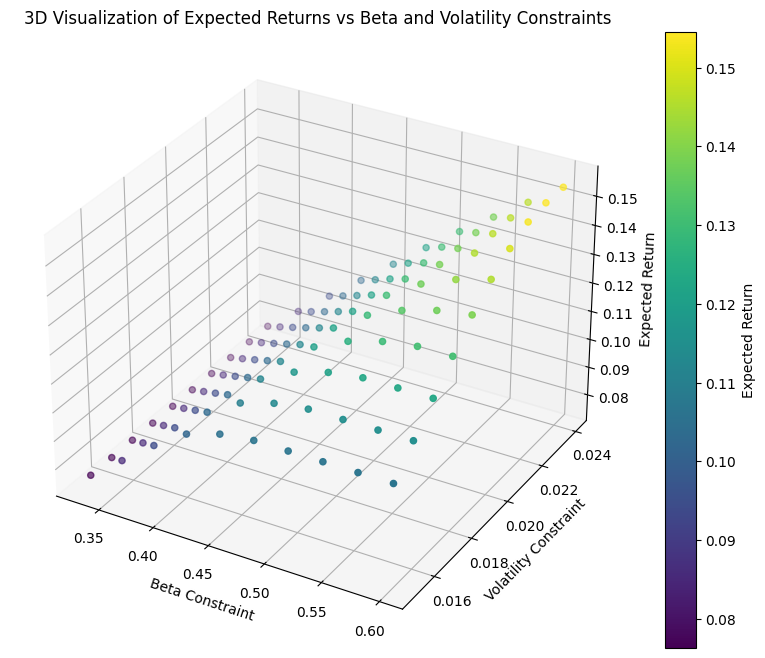

In [799]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(df['beta_iter'], df['vol_iter'], df['expected_return'], c=df['expected_return'], cmap='viridis')

# Labeling
ax.set_xlabel('Beta Constraint')
ax.set_ylabel('Volatility Constraint')
ax.set_zlabel('Expected Return')

# Color bar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Expected Return')

plt.title('3D Visualization of Expected Returns vs Beta and Volatility Constraints')
plt.show()


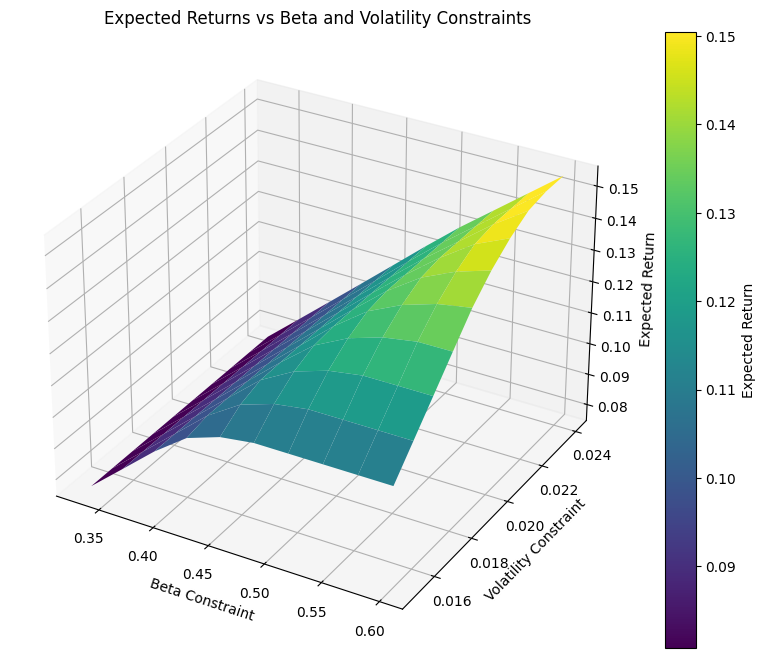

In [800]:
pivot_df = df.pivot_table(index='vol_iter', columns='beta_iter', values='expected_return')

# Create meshgrid for beta and volatility
beta_mesh, vol_mesh = np.meshgrid(pivot_df.columns, pivot_df.index)

# Extracting the expected returns for the meshgrid
expected_returns_mesh = pivot_df.values

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting the surface
surface = ax.plot_surface(beta_mesh, vol_mesh, expected_returns_mesh, cmap='viridis')

# Labeling
ax.set_xlabel('Beta Constraint')
ax.set_ylabel('Volatility Constraint')
ax.set_zlabel('Expected Return')

# Color bar
cbar = plt.colorbar(surface, ax=ax)
cbar.set_label('Expected Return')

plt.title('Expected Returns vs Beta and Volatility Constraints')
plt.show()

### Conclusion
As noted by the visuals, extra reward (expected returns) are achieved by loosening volatility and beta constraints. 

This illustrates the essense of Modern Portfolio Theory with the tradeoffs between risk and reward. 

In [17]:
%gams_cleanup --closedown